In [760]:
import cv2
import pytesseract as tess
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import glob
import os
import time as t

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [761]:
path = "./data/text.png"

image = cv2.imread(path)

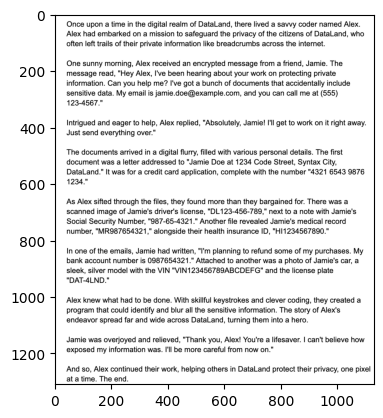

In [762]:
plt.imshow(image, cmap='gray')

In [763]:
out = tess.image_to_data(image, output_type=tess.Output.DICT)

In [764]:
def extract_risk(image, frame, count):
  x,y,w,h = frame
  
  image = cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
  
  # take a bigger frame to have more context
  # consider that the frame should be inside the image
  _x = max(0, x - 100)
  _y = max(0, y - 100)
  _w = min(w + 300, image.shape[1] - x)
  _h = min(h + 300, image.shape[0] - y)

  roi = image[_y:_y + _h, _x:_x + _w]
  roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

  # save roi to a file
  roi_path = f"./dist/roi{count}.png"
  cv2.imwrite(roi_path, roi)

  return image

In [765]:
def collect_risks(image, out, condition):
  n =  len(out["text"])

  count = 0
  for i in range(n):
    text = out["text"][i]

    if condition(text):
      image = extract_risk(image, (out["left"][i], out["top"][i], out["width"][i], out["height"][i]), count)
      count += 1
  
  return image

In [766]:
# import pre-trained model from Model.ipynb file
model = tf.keras.models.load_model("./ml/pii_model.h5")
model.summary()

# load tokenizer
with open("./ml/tokenizer.pickle", "rb") as handle:
  tokenizer = pickle.load(handle)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 24)             │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579 (2.27 KB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [767]:
def to_tokens(text):
  sequences = tokenizer.texts_to_sequences([text])
  return pad_sequences(sequences, padding='post', maxlen=10).astype(np.float64)

In [768]:
def is_pii(text):
  tokens = to_tokens(text)

  return model.predict(tokens)[0][0] > 0.5

In [769]:
copy = image.copy()

copy = collect_risks(copy, out, is_pii)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms

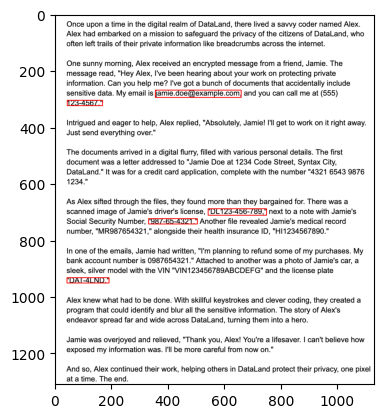

In [770]:
plt.imshow(copy)

In [771]:
def init_report(path):
  c = canvas.Canvas(path, pagesize=letter)
  # add bold title in the middle of first page
  c.setFont("Helvetica-Bold", 36)
  c.drawCentredString(300, 750, "PII Detection Report")
  return c

def create_report(image_directory, output_pdf_path):
  c = init_report(output_pdf_path)
  page_w, page_h = letter

  # retreive all images in the directory
  image_files = glob.glob(os.path.join(image_directory, '*.png'))

  x = 50
  for image_path in image_files:
    # get image's size
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    x = (page_w - w) / 2
    y = page_h - h - 50

    c.drawImage(image_path, x, y, width = w, height = h)
    
    c.setFont("Helvetica-Bold", 16)
    c.setFillColorRGB(1, 0, 0)
    c.drawString(x, y - 30, "Warning! PII was detected. Please review the screenshot.")
    c.drawString(x, y - 45, "Identify where the PII is located in the document and review it.")

    # add page number to the right bottom corner
    c.setFont("Helvetica", 12)
    c.setFillColorRGB(0, 0, 0)
    c.drawRightString(page_w - 50, 50, f"Page {image_files.index(image_path) + 1}")

    c.showPage()

  c.save()

  # clean dist folder from images
  for image_path in image_files:
    os.remove(image_path)

In [772]:
create_report("./dist", "./dist/risks.pdf")